## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import pandas as pd

In [3]:
# set random seed
import tensorflow as tf
seed(10)
tf.random.set_seed(10)

# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [18]:
# load, average and merge sensor samples
data_dir = r'/Users/zhaoxikun/Desktop/LSTM-Autoencoder-for-Anomaly-Detection-master/Data/bearing_data'
merged_data = pd.DataFrame()
for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), encoding='utf-8',sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    if filename==".DS_Store":
        continue
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data._append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [19]:
# transform data file index to datetime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [20]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


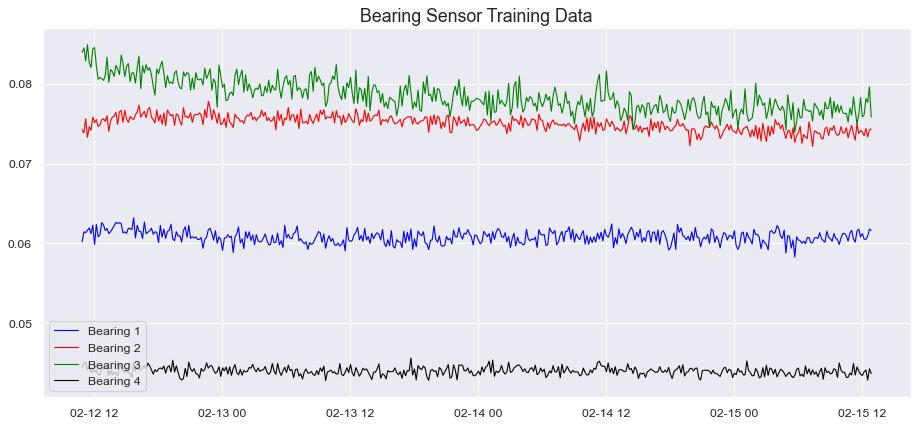

In [21]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

让我们通过离散傅里叶变换将信号从时域转换到频域，从另一个角度了解数据。

In [40]:
# # 使用快速傅立叶变换将数据从时域转换到频域
print(train)
train_fft = np.fft.fft(train)
print(train_fft)
test_fft = np.fft.fft(test)

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-12 10:52:39   0.060236   0.074227   0.083926   0.044443
2004-02-12 11:02:39   0.061455   0.073844   0.084457   0.045081
2004-02-12 11:12:39   0.061361   0.075609   0.082837   0.045118
2004-02-12 11:22:39   0.061665   0.073279   0.084879   0.044172
2004-02-12 11:32:39   0.061944   0.074593   0.082626   0.044659
...                        ...        ...        ...        ...
2004-02-15 12:12:39   0.060542   0.073487   0.076082   0.043940
2004-02-15 12:22:39   0.060525   0.074383   0.078142   0.044174
2004-02-15 12:32:39   0.060920   0.073339   0.077637   0.042915
2004-02-15 12:42:39   0.061789   0.074205   0.079595   0.044318
2004-02-15 12:52:39   0.061652   0.074332   0.075826   0.043743

[445 rows x 4 columns]
[[ 0.26283222+0.j         -0.02368963-0.02978353j  0.0254928 +0.j
  -0.02368963+0.02978353j]
 [ 0.26483837+0.j         -0.023002  -0.02876268j  0.0269874 +0.j
  -0.023002  +0.02876268j]
 [ 0.2649247 +0.j     

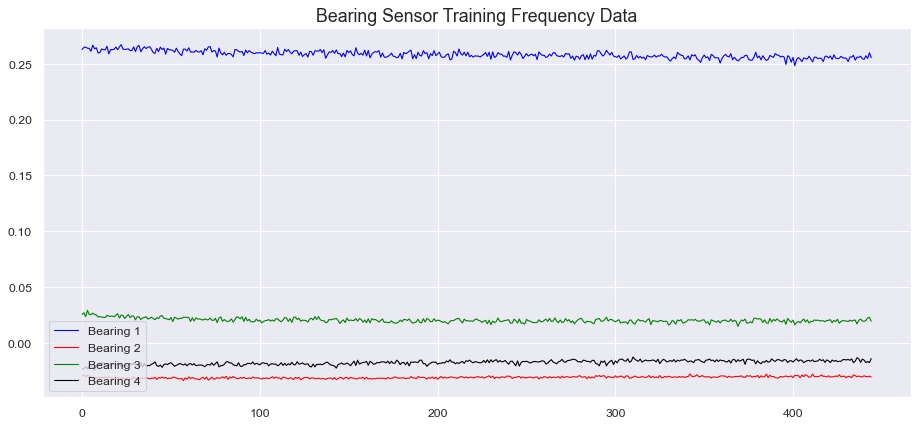

In [23]:
# 频率信号，经过傅里叶变化后时域变为频域
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

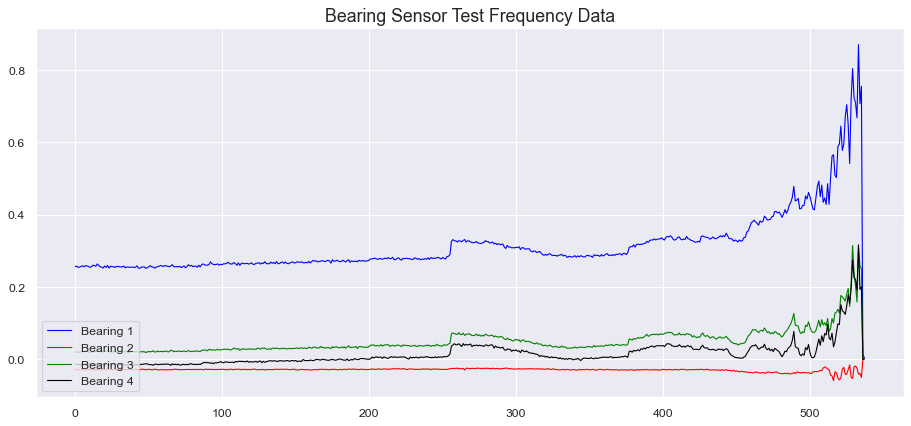

In [24]:
# 传感器信号衰减的频率
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [41]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [42]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print(X_train)
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

[[[0.39518051 0.36851684 0.91295856 0.56833449]]

 [[0.64304579 0.30094449 0.96148238 0.79465028]]

 [[0.62379364 0.61266227 0.81348964 0.80775623]]

 ...

 [[0.53419516 0.21178246 0.33869465 0.02647161]]

 [[0.71083045 0.36463536 0.51749078 0.52396122]]

 [[0.68310894 0.38704446 0.17330254 0.32004848]]]
Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [27]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)## 使用 "RepeatVector" 将 Encoder 的输出(最后一个 time step)复制 N 份作为 Decoder 的 N 次输入
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [28]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 4)              │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 16)          │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 4)           │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,236 (12.64 KB)

 Trainable params: 3,236 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4599 - val_loss: 0.3222
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.4031 - val_loss: 0.2531
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.3269 - val_loss: 0.1678
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.2150 - val_loss: 0.1389
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.1155 - val_loss: 0.1239
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.1058 - val_loss: 0.1194
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.1030 - val_loss: 0.1166
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 0.1014 - val_loss: 0.1143
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.1008 - val_loss: 0.1135
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1005 - val_loss: 0.1131
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.1002 - val_loss: 0.1124
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 79

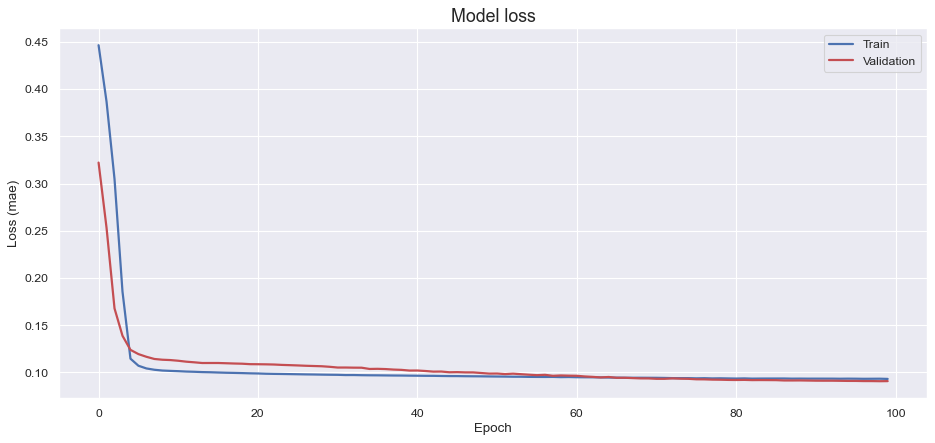

In [30]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step


/var/folders/7m/k3blj9rd7z5gr9_h9cz6j58m0000gn/T/ipykernel_38540/3269023118.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

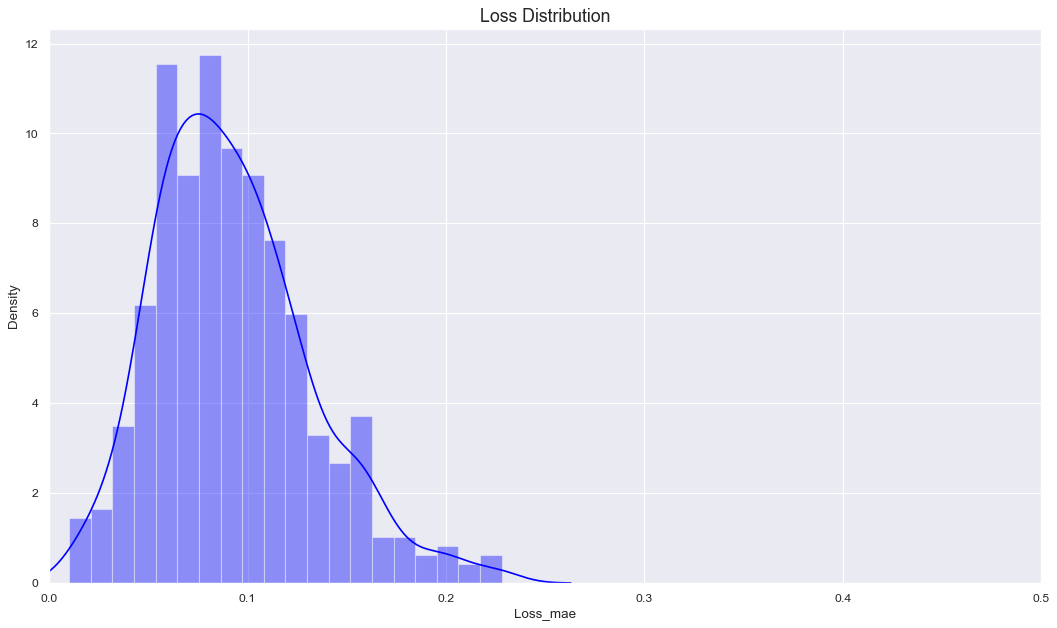

In [33]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [34]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.090098,0.275,False
2004-02-15 13:02:39,0.169258,0.275,False
2004-02-15 13:12:39,0.064871,0.275,False
2004-02-15 13:22:39,0.058045,0.275,False
2004-02-15 13:32:39,0.037543,0.275,False


In [35]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<Axes: >

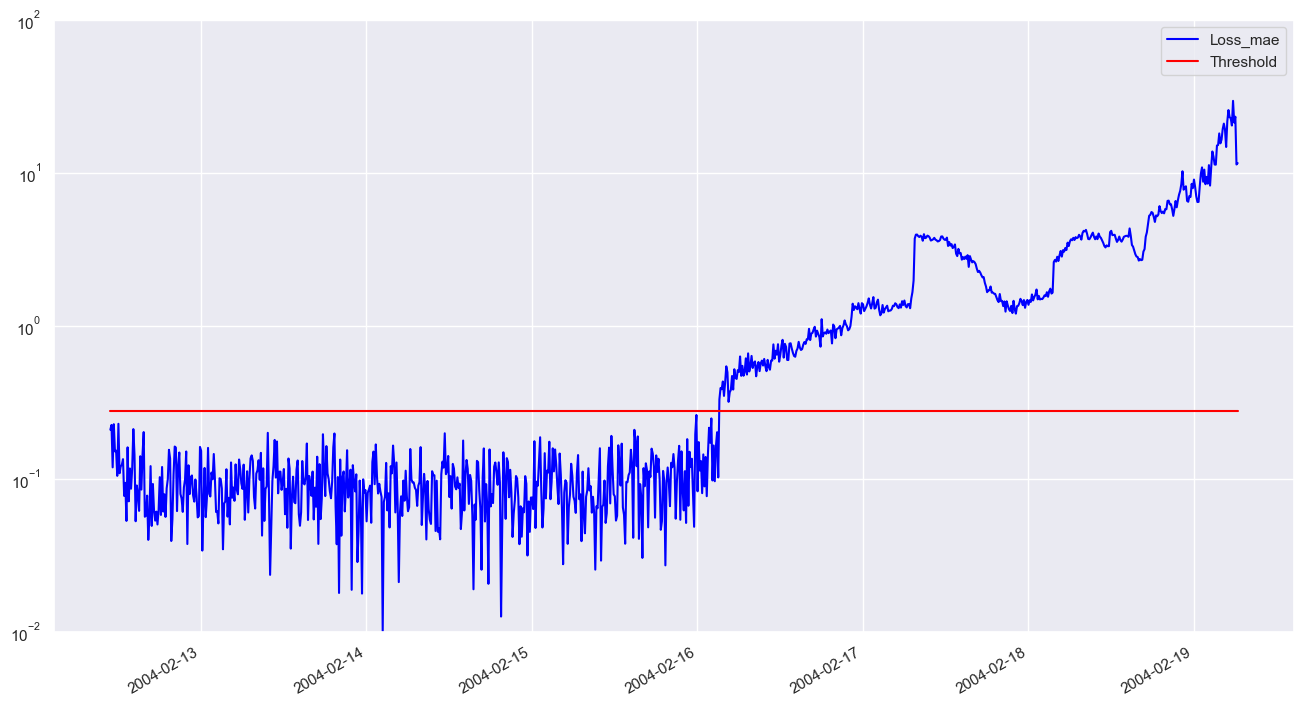

In [36]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [22]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
